# Figure: Cal beads simulation

Neerja Aggarwal
May 20th, 2024
Purpose: simulate measurement and reconstruction from different optical configurations.


## Import

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import os
import sys

sys.path.append('../../ReconCode')
try:
    import sdc_jax as sdc
    print("Successfully imported sdc_jax")
except ImportError as e:
    print(f"Error importing sdc_jax: {e}")

import jax.numpy as jnp
import jax
import optax
# figures helper functions
%run figures_util.py
# from cleanplots import *

# CHOOSE GPU
%load_ext autoreload
%autoreload 2
import os
import sys
gpu = 3

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

Successfully imported sdc_jax


## System Parameters

In [3]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 1
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

mag_size = 4*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor
gt_pixel_size = 4.4 # um
gt_mag_size = 4*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um



## choose spectra

AttributeError: module 'sdc_jax' has no attribute 'pad'

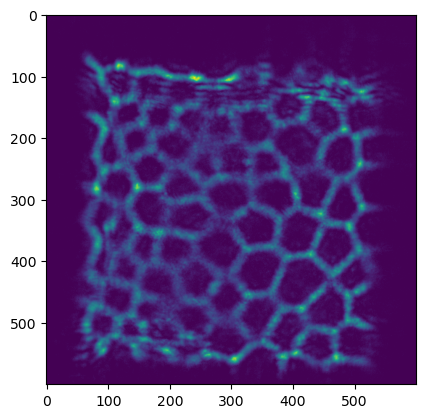

In [ ]:
calibration_location = '../Calibration_data'
psf_name = 'psf_2024-04-22.npy'
calibration_wavelengths_file = 'wavelengths_2024-02-23.npy'
filter_cube_file = 'spectral_filter_2024-02-23.npy'
crop_indices = [600,1200,1400,2000] #top bottom left default: [320,1652,1350,2726]

# Load and crop filter cube
wv = np.load(os.path.join(calibration_location,calibration_wavelengths_file))
normalized_filter_cube = jnp.load(os.path.join(calibration_location, filter_cube_file))
filterstack = sdc.cropci(normalized_filter_cube, crop_indices)
msum = sdc.sumFilterArray(filterstack, wv,wvmin,wvmax,wvstep)
spectral_filter = msum / jnp.amax(msum)
spectral_filter = spectral_filter - jnp.amin(spectral_filter, axis=0, keepdims=True)[0]
(dim0,dim1,dim2) = spectral_filter.shape

# Load and crop PSF
sensor_psf = jnp.load(os.path.join(calibration_location, psf_name))
psf = sdc.center_crop(sensor_psf, spectral_filter.shape[1:])
psf = psf / jnp.sum(psf)
psf = psf.clip(0)


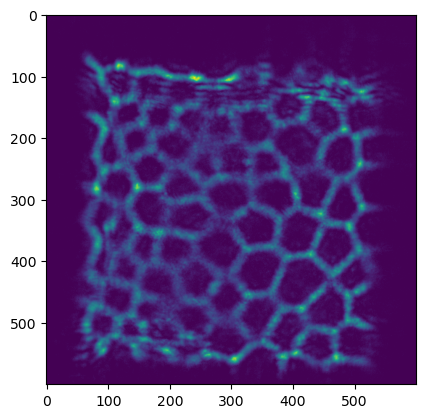

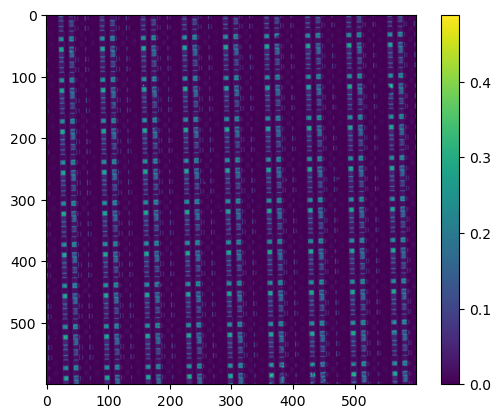

In [69]:
plt.figure()
plt.imshow(psf)
xk = jnp.zeros_like(spectral_filter)
padding = (
    (0, 0, 0),
    (np.ceil(xk.shape[1] / 2).astype(int), np.floor(xk.shape[1] / 2).astype(int), 0),
    (np.ceil(xk.shape[2] / 2).astype(int), np.floor(xk.shape[2] / 2).astype(int), 0),
)
hpad = jax.lax.pad(psf[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)


plt.figure()
plt.imshow(spectral_filter[0,:,:])
plt.colorbar()

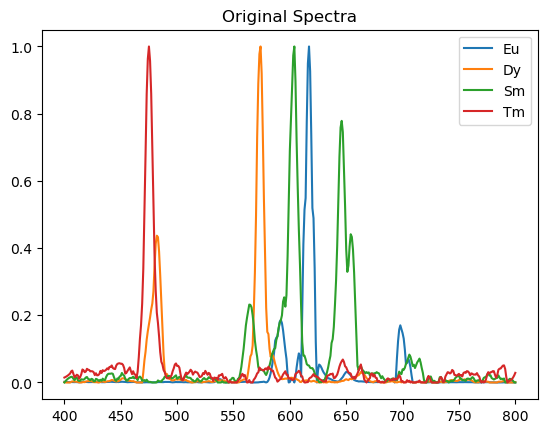

<Figure size 640x480 with 0 Axes>

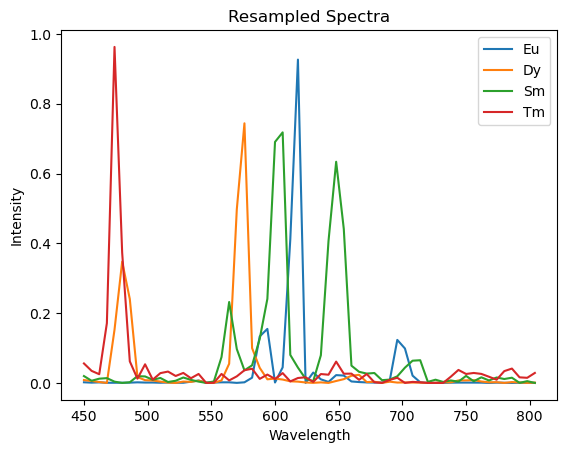

In [16]:
from scipy.signal import savgol_filter

# plot the ground truth spectra
# Specify the file path of the CSV file
file_path = "mrbles_spectra_20230412.csv"
# Read the CSV file into a NumPy array
data = np.genfromtxt(file_path, delimiter=',')
# Extract the wavelengths and spectra from the data
wavelengths_gt = data[1:, 0]
spectra_gt = data[1:, 2:7] - np.expand_dims(data[1:,1], axis = 1)
# remove the Dy duplicate
spectra_gt = np.delete(spectra_gt, 1, axis=1)
mrblesnew = np.zeros((spectra_gt.shape[1], len(wavelengths)))

# Remove the peak near 580
idx = np.where((wavelengths_gt >= 582) & (wavelengths_gt <= 592))[0]
peakstart = idx[0]
peakend = idx[-1]

for i in range(0, spectra_gt.shape[1]):
    spec = spectra_gt[:, i]
    spec[idx[0]:idx[-1]] = np.linspace(spec[idx[0]-1], spec[idx[-1]+1], idx[-1] - idx[0])  # remove the peak near 580
    spectra_gt[:, i] = spec
    #filter with savitzky golay
    spectra_gt[:, i] = savgol_filter(spectra_gt[:, i], window_length=11, polyorder=2)
    # normalize the spectra
    spectra_gt[:, i] = spectra_gt[:, i] / np.amax(spectra_gt[:, i])
    # remove negative values
    spectra_gt[:, i] = np.maximum(spectra_gt[:, i], 0)
    mrblesnew[i,:] = np.interp(wavelengths, wavelengths_gt, spectra_gt[:, i])
gt_idx = 0

plt.figure()
plt.plot(wavelengths_gt, spectra_gt)
labels =['Eu', 'Dy', 'Sm','Tm']
plt.legend(labels)
plt.title('Original Spectra')

plt.figure()
plt.figure()
for i in range(mrblesnew.shape[0]):
    plt.plot(wavelengths, mrblesnew[i, :])
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
labels =['Eu', 'Dy', 'Sm','Tm']
plt.legend(labels)
plt.title('Resampled Spectra')
plt.show()


# resample at wavelengths


# Draw CAL

In [17]:
#initialize x 
#choose size for beads. 
import imgviz

def placeBead(src, bcenter, bdiam, spectra=None):
    #place bead at location
    #if its a flat 2d image, then just place bead and return image
    if len(src.shape)<= 2:
        xout = imgviz.draw.circle(src, bcenter, bdiam, fill=1)
        return xout
    #else if it's 3d image, then place bead with spectra
    if len(src.shape)>2:
        xoutfull = src #make a copy to be safe
        #get index of where bead should go
        xout = imgviz.draw.circle(src[:,:,0], bcenter, bdiam, fill=1)
        a = np.where(xout ==1)
        pmax = len(a[0])
        for p in range(pmax):
            yval = a[0][p]
            xval = a[1][p]
            xoutfull[yval,xval,:] = spec
        return xoutfull
    return src

def genBeadloc(src,numBeads,specnum=1,buffer=0):
    (dim0,dim1,dim2) = src.shape
    yloc = np.random.randint(0+buffer,dim0-buffer,numBeads)
    xloc = np.random.randint(0+buffer,dim1-buffer,numBeads)
    s = np.random.randint(0,specnum,numBeads)
    return (yloc,xloc,s)

#use draw.circle to get indices
#then change indices myself

(-0.5, 599.5, 599.5, -0.5)

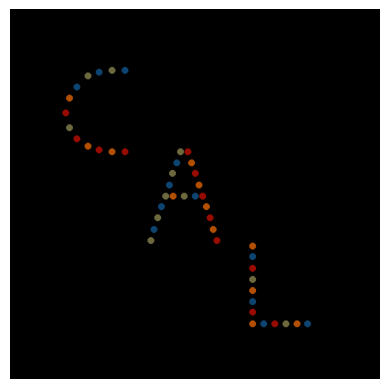

In [27]:
xsamples = dim1
ysamples = dim2
bead_loc = []

#The Letter C
bead_loc.append((int(.28*xsamples),int(.15*ysamples)))
bead_loc.append((int(.32*xsamples),int(.16*ysamples)))
bead_loc.append((int(.24*xsamples),int(.16*ysamples)))
bead_loc.append((int(.21*xsamples),int(.18*ysamples)))
bead_loc.append((int(.35*xsamples),int(.18*ysamples)))
bead_loc.append((int(.18*xsamples),int(.21*ysamples)))
bead_loc.append((int(.37*xsamples),int(.21*ysamples)))
bead_loc.append((int(.17*xsamples),int(.24*ysamples)))
bead_loc.append((int(.38*xsamples),int(.24*ysamples)))
bead_loc.append((int(.165*xsamples),int(.275*ysamples)))
bead_loc.append((int(.385*xsamples),int(.275*ysamples)))
bead_loc.append((int(.165*xsamples),int(.31*ysamples)))
bead_loc.append((int(.385*xsamples),int(.31*ysamples)))


# The Letter A
bead_loc.append((int(.505*xsamples),int(.47*ysamples)))
bead_loc.append((int(.505*xsamples),int(.44*ysamples)))
bead_loc.append((int(.505*xsamples),int(.5*ysamples)))
for ii in range(1,10):
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47+ii*.01)*ysamples)))
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47-ii*.01)*ysamples)))


# The Letter L
for ii in range(1,9):
    bead_loc.append((int((.61+ii*.03)*xsamples),int(.655*ysamples)))
for ii in range(1,7):
    bead_loc.append((int(.85*xsamples),int((.625+ii*.03)*ysamples)))

bdiam = 10
xinit = np.zeros_like(msum)   
# reorder the dimensions to be compatible with the function
xinit = np.transpose(xinit, (1, 2, 0))
for k in range(len(bead_loc)):
    #spec = mrblesnew[torch.randint(5,(1,1)),:]
    spec = mrblesnew[np.mod(k,len(mrblesnew)),:] #cycle through
    xcal = placeBead(xinit, bead_loc[k],bdiam, spectra = spec)

plt.figure()
HSI_data = np.reshape(xcal, [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)
plt.axis('off')

### diffuser measurement

In [38]:
# simulate regular diffusercam forwrd model. 
# Load and crop PSF

x = np.transpose(xcal, (2, 0, 1))
# move calibration to jax
psf_diffuser = psf
y_diffuser = sdc.jax_forward_model(x,spectral_filter, hfftpad)

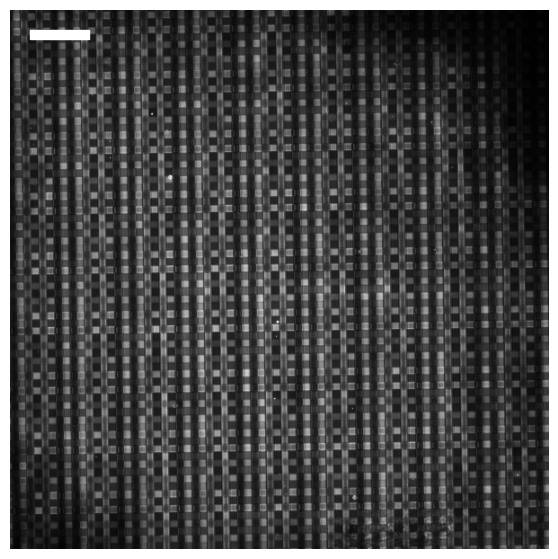

In [54]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_diffuser**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.02])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### original measurement

In [77]:
# simulate with delta psf. 
psf_delta = np.zeros_like(psf)
psf_delta[psf_delta.shape[0]//2,psf_delta.shape[1]//2] = 1
hpad = jax.lax.pad(psf_delta[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_delta = sdc.jax_forward_model(x, spectral_filter, hfftpad)

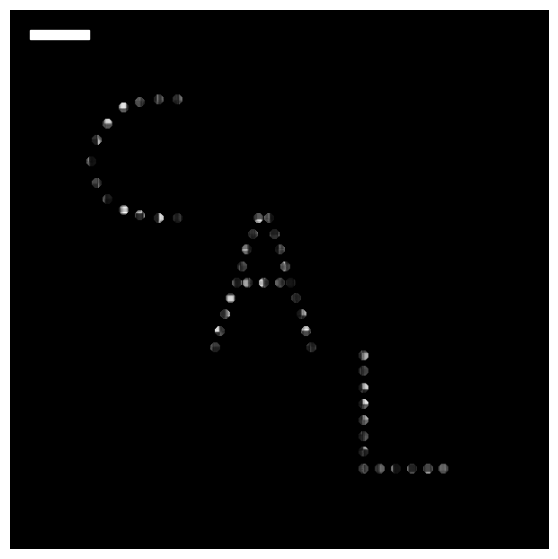

In [78]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_delta**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.5])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### magnified measurement

In [79]:
from jax.image import resize
# Define the scale factor and new shape
scale_factor = 8
zoom_size = (int(x.shape[1]/scale_factor), int(x.shape[2]/scale_factor))
# crop the original image
xzoom = sdc.jax_crop2D(zoom_size,x)

# Scale the array using bilinear interpolation
xmag = resize(np.asarray(xzoom), x.shape, method='linear')
y_mag = sdc.jax_forward_model(xmag, spectral_filter, hfftpad)

(-0.5, 599.5, 599.5, -0.5)

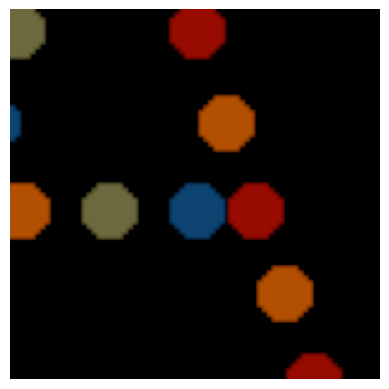

In [80]:
plt.figure()
HSI_data = np.reshape(np.transpose(xmag, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)
plt.axis('off')

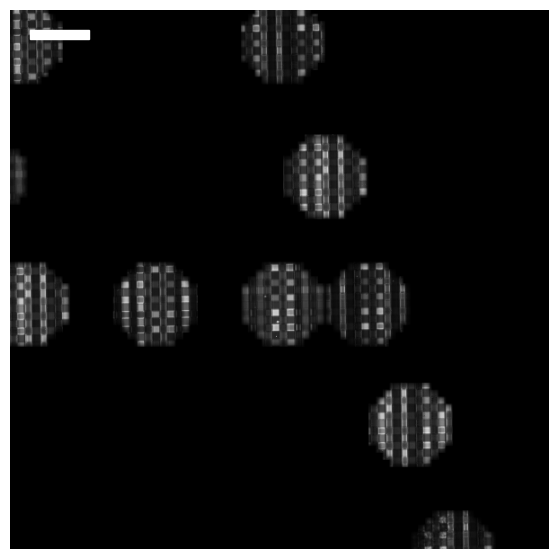

In [81]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_mag**.5, cmap='gray')
# plt.colorbar()  
plt.clim([0,1])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## defocused measurement

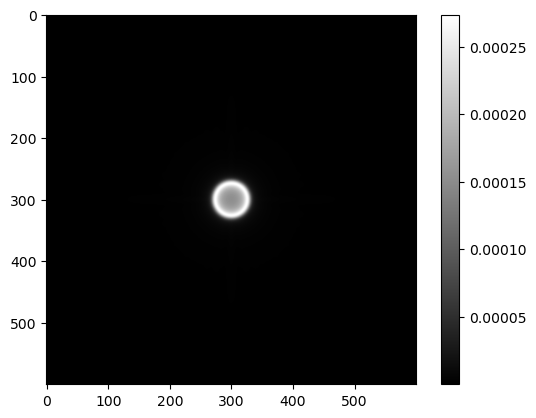

In [82]:
# use simulation to get defocused psf. 

# create quadratic phase...
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
size = [psf.shape[0],psf.shape[1]] # Grid size
source = np.array([0,0, 0])  # Source location (y,x,z) in micron
wavelength = 500e-3 # Wavelength # 500 nm in um
pixsize =  wavelength/20 # Pixel size in micron
amplitude = 1  # Wave amplitude

# Create a 2D grid
x1 = np.linspace(-size[1]*pixsize/2, size[1]*pixsize/2, size[1])
y1 = np.linspace(-size[0]*pixsize/2, size[0]*pixsize/2, size[0])
z1 = 2  # microns above source
X, Y= np.meshgrid(x1, y1)

# Calculate the distance from the source
R = np.sqrt((X - source[1])**2 + (Y - source[0])**2 + (z1 - source[2])**2)

# Calculate the phase
phase = 2*np.pi/wavelength * R
amp = amplitude/R
# circle aperture
aperture = np.zeros_like(X)
r = np.sqrt((X)**2 + (Y)**2)
aperture[r<np.amax(X)] = 1

uxy = amp*np.exp(1j * phase)*aperture

fuxy = np.fft.fftshift(np.fft.fft2(uxy))

from scipy.ndimage import gaussian_filter
psf_defocus = np.abs(gaussian_filter(np.abs(fuxy), sigma=3))
psf_defocus = psf_defocus/np.sum(psf_defocus)

plt.figure()
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()


/tmp/ipykernel_2832074/1575900754.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
/tmp/ipykernel_2832074/1575900754.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))


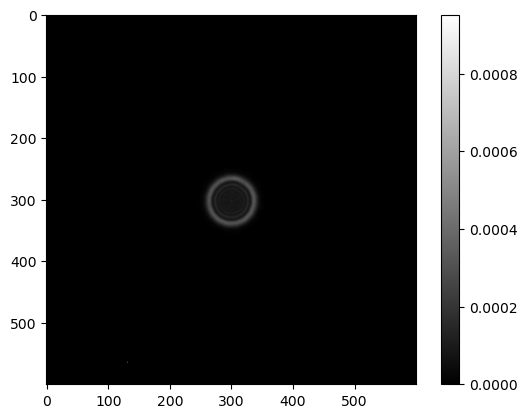

In [83]:
# use measurement instead. 
# read numpy array from image
import imageio

# Load the BMP image
defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))

cen = np.argmax(focused_bmp)
cen = np.unravel_index(cen, focused_bmp.shape)

#crop arround defocused image

psf_defocus = defocused_bmp[cen[0]-int(psf_diffuser.shape[0]/2):cen[0]+int(psf_diffuser.shape[0]/2),cen[1]-int(psf_diffuser.shape[1]/2):cen[1]+int(psf_diffuser.shape[1]/2)]
# Convert the image to a numpy array
#subtract background
psf_defocus = psf_defocus - np.amin(psf_defocus)
psf_defocus = psf_defocus/np.sum(psf_defocus)
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()

In [87]:
hpad = jax.lax.pad(psf_defocus[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_defocus = sdc.jax_forward_model(x, spectral_filter, hfftpad)


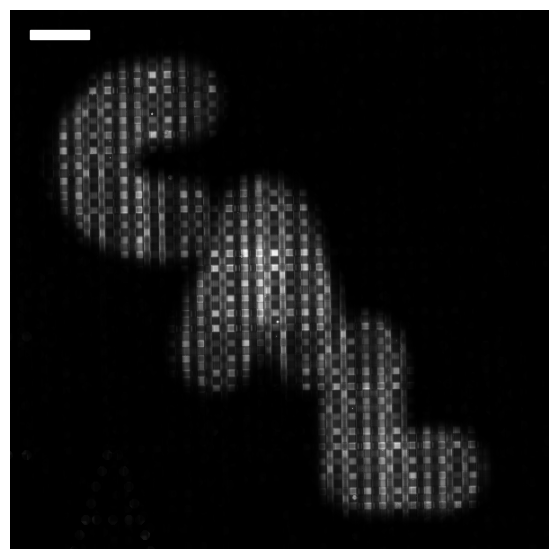

In [89]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_defocus**.5, cmap='gray')
# plt.colorbar()
# plt.clim([0,.07])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### blurred measurement


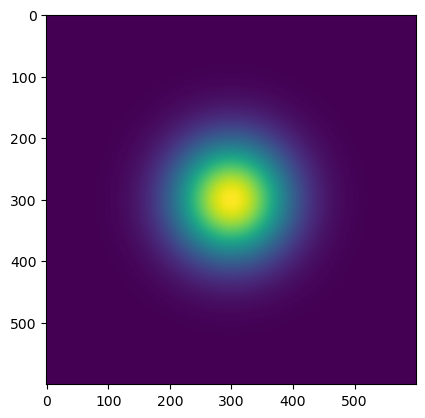

In [90]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Create a PSF with a Gaussian blur
psf_blur = np.zeros_like(psf)
psf_blur[int(psf_blur.shape[0] / 2), int(psf_blur.shape[1]/2)] = 1.0  # Set the center pixel to 1.0
psf_blur = gaussian_filter(psf_blur, sigma=66.0)  # Apply Gaussian blur with sigma=1.0

# Normalize the PSF
psf_blur /= np.sum(psf_blur)

plt.imshow(psf_blur)

In [91]:
# simulate with blur psf. 

hpad = jax.lax.pad(psf_blur[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_blur = sdc.jax_forward_model(x, spectral_filter, hfftpad)

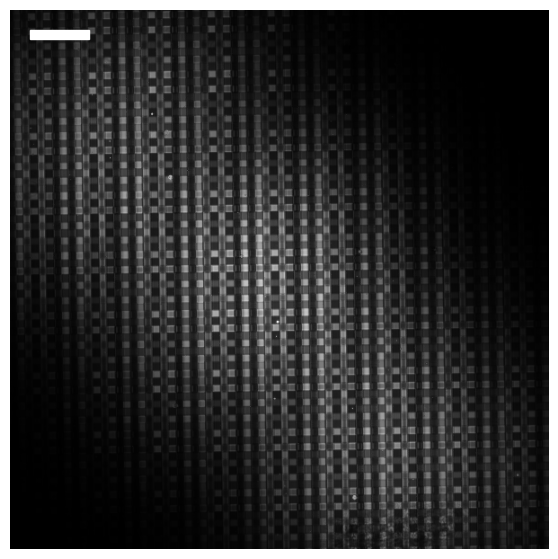

In [92]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_blur**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.03])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## add noise to the measurements

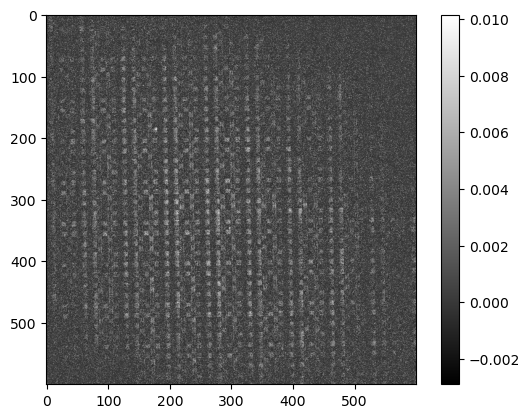

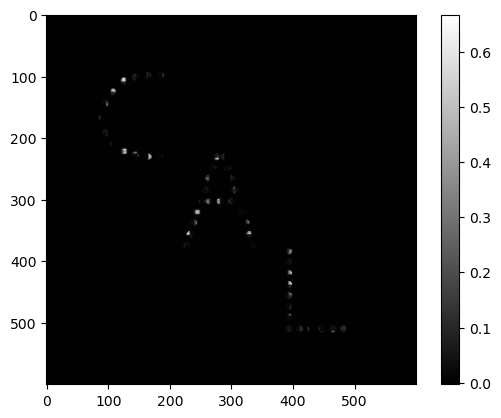

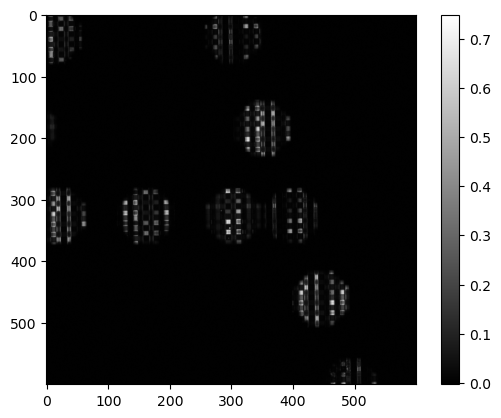

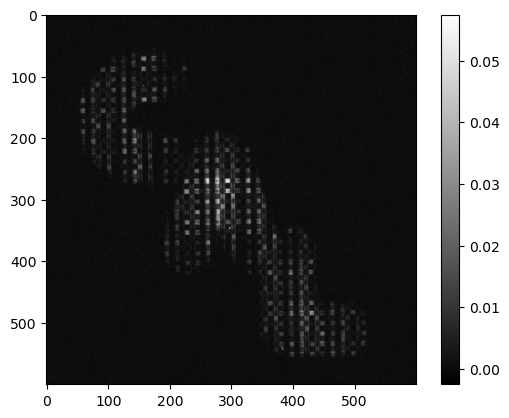

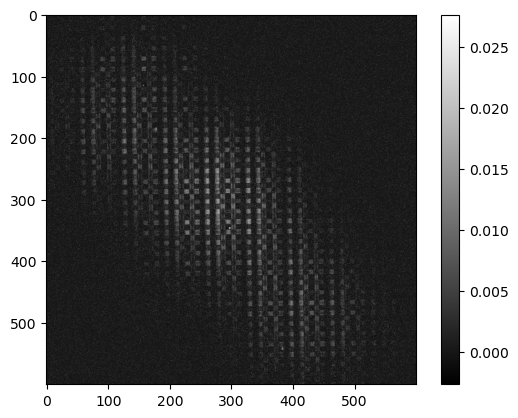

In [107]:
# stack all the measurements and psfs
meas_stack = [y_diffuser, y_delta, y_mag, y_defocus, y_blur]
psf_stack = [psf_diffuser, psf_delta, psf_delta, psf_defocus, psf_blur]
scale_factor_to_int = 2**16
noisy_meas_stack = [np.zeros_like(meas) for meas in meas_stack]
poisson_lambda_scale = 1
gaussian_noise_std = 100 # add some noise to the background dark pixels

for k in range(len(meas_stack)):
    meas = meas_stack[k]
    meas_int = (meas*scale_factor_to_int).astype(np.int32)
    poisson_noise = np.random.poisson(meas_int/poisson_lambda_scale)
    gauss_noise = np.random.normal(0,gaussian_noise_std, size = meas.shape)
    noisy_meas = (poisson_noise+meas_int+gauss_noise)/scale_factor_to_int
    # clip negative values to zero. 
    noisy_meas = jnp.where(noisy_meas < 0, 0, noisy_meas)
    noisy_meas_stack[k] = noisy_meas
    plt.figure()
    plt.imshow(noisy_meas_stack[k]-meas, cmap = 'gray')
    plt.colorbar()





## Save the measurements and create configs

In [113]:
[N1,N2,N3] = normalized_filter_cube.shape
padding = ((crop_indices[0],N2-crop_indices[1],0),(crop_indices[2],N3-crop_indices[3],0))
test_pad = jax.lax.pad(meas_stack[0], 0.0, padding).squeeze()

print(test_pad.shape)
print(normalized_filter_cube.shape)

(2048, 3072)
(261, 2048, 3072)


In [118]:
# save the measurements and psfs in a folder
import tifffile

# Create a folder for the measurements and psfs
measurement_folder = 'sim_data'

# Create the folder if it doesn't exist
folder_names = ['diffuser', 'delta', 'mag', 'defocus', 'blur']

[N1,N2,N3] = normalized_filter_cube.shape
padding = ((crop_indices[0],N2-crop_indices[1],0),(crop_indices[2],N3-crop_indices[3],0))
bits = 16  

HSI_data = np.reshape(xcal, [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)

for k in range(len(meas_stack)):
    pathname = os.path.join(measurement_folder, folder_names[k])
    # create folder if it doesn't exist
    if not os.path.exists(pathname):
        os.makedirs(pathname)
    # save the meas as tiff file
    padded_meas = jax.lax.pad(meas_stack[k], 0.0, padding).squeeze()
    tifffile.imwrite(os.path.join(pathname, 'meas.tiff'), (padded_meas* 65535).astype(np.uint16))
    # save the psf as npy file
    np.save(os.path.join(pathname, 'psf.npy'), psf_stack[k])
    # save the object file as gt.tiff
    tifffile.imwrite(os.path.join(pathname, 'gt.tiff'), (false_color* 65535).astype(np.uint16))   


In [ ]:
# create the config files. 
config_folder = 'sim_configs'
if not os.path.exists(config_folder):
    os.makedirs(config_folder)




## Do the reconstructions

0


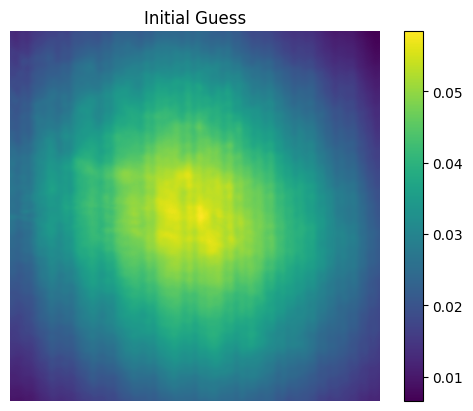

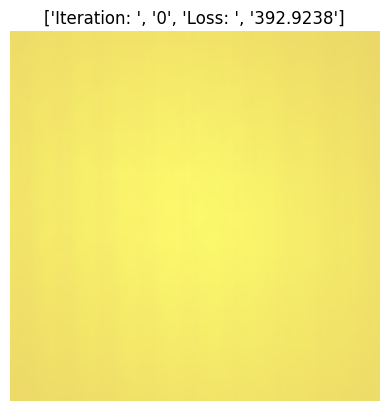

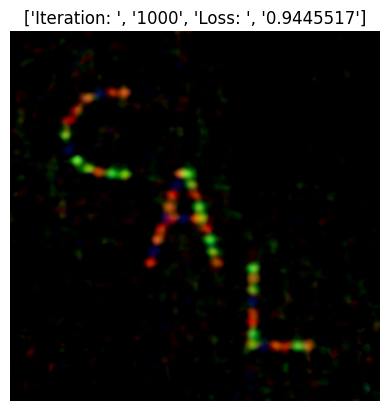

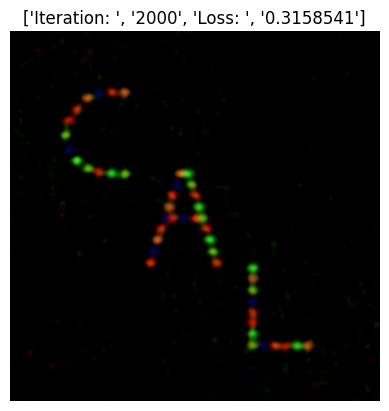

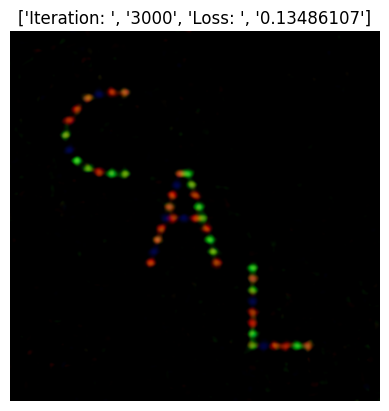

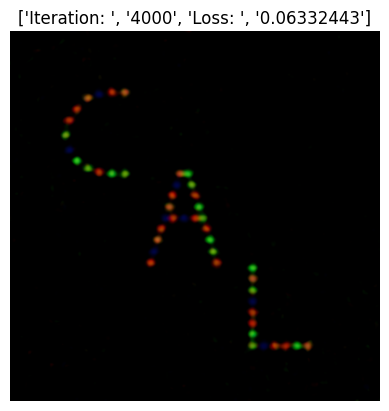

1


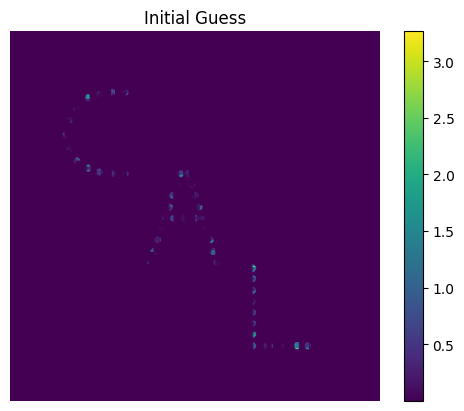

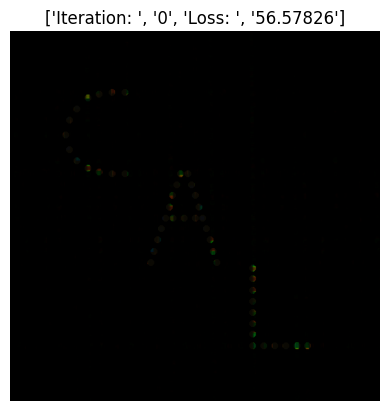

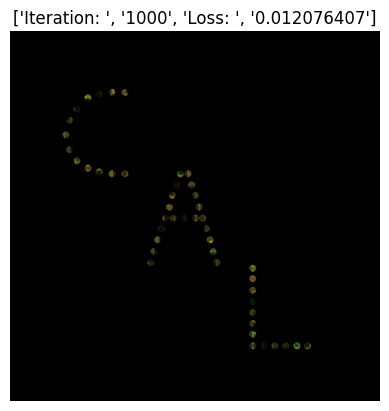

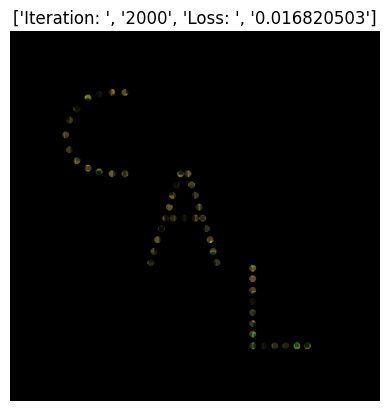

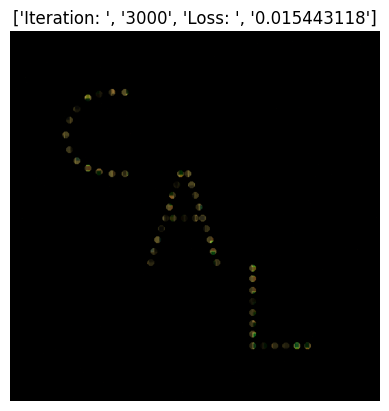

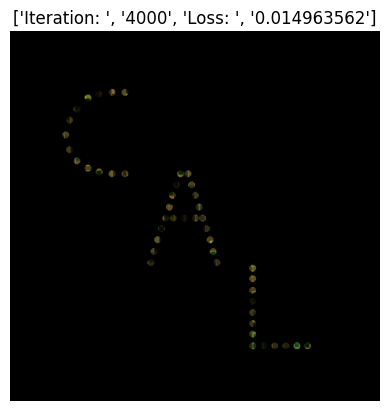

2


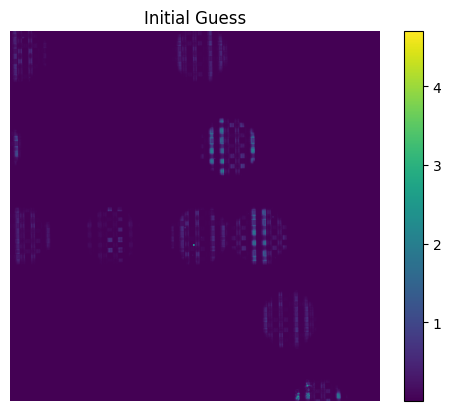

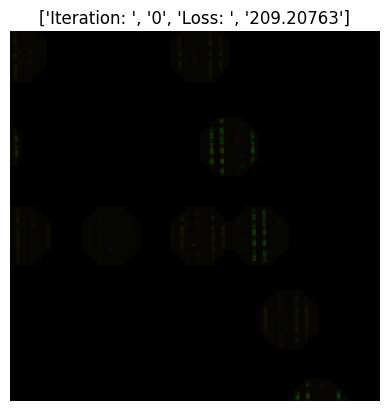

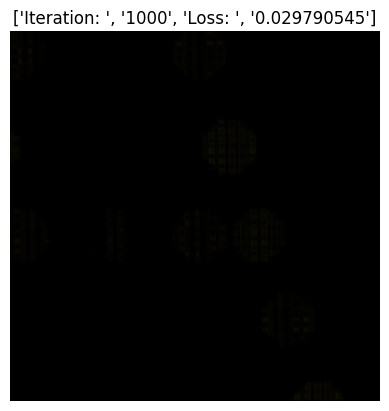

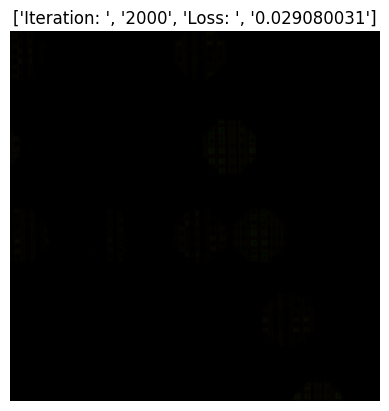

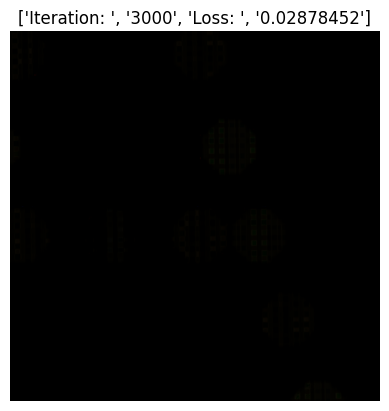

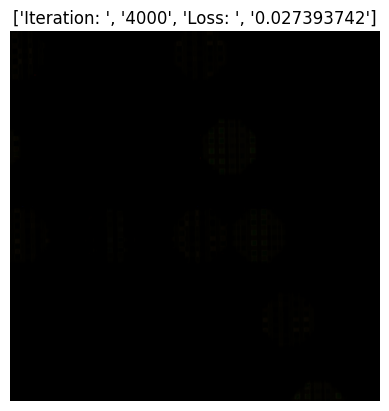

3


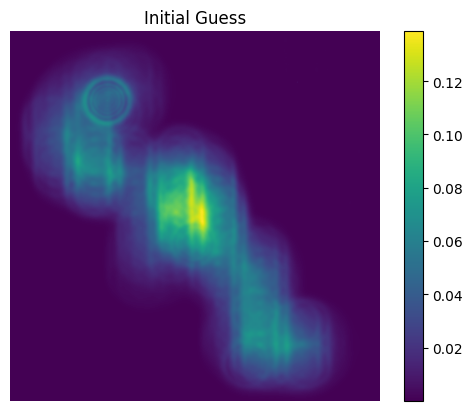

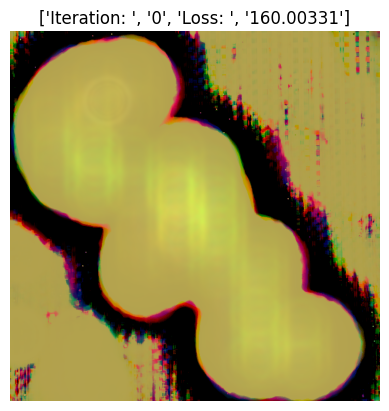

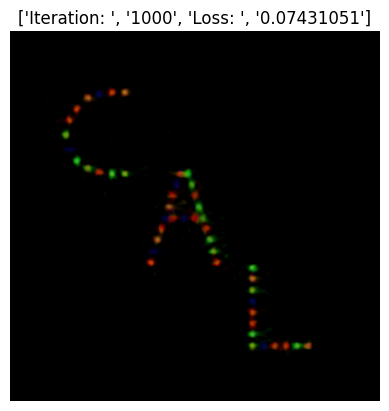

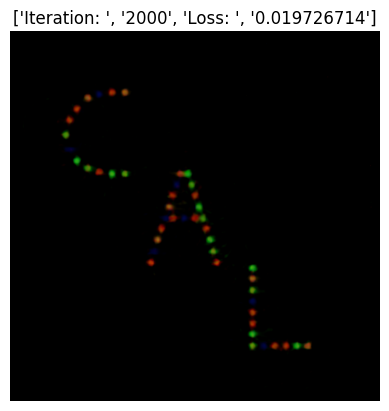

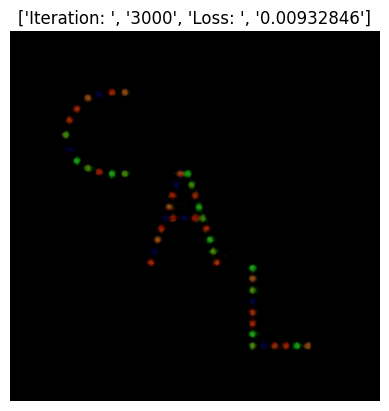

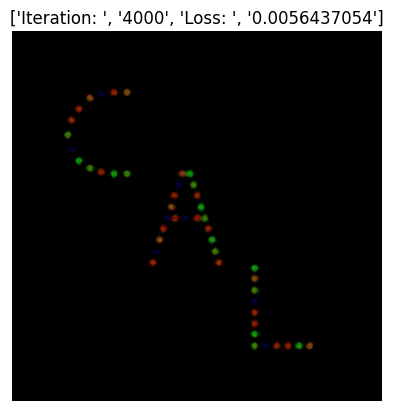

4


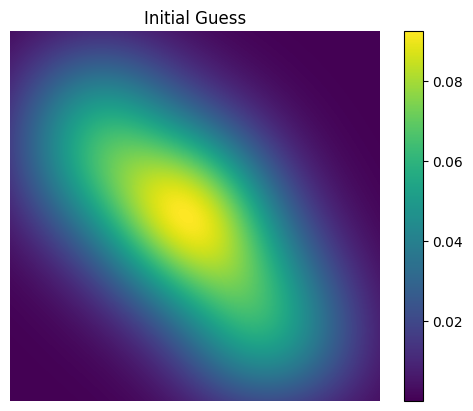

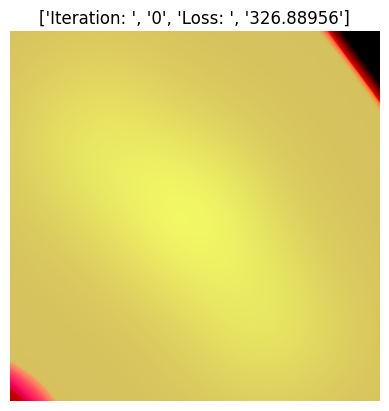

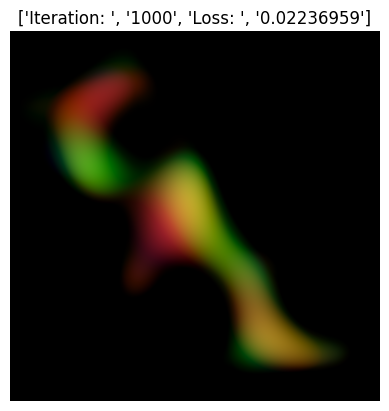

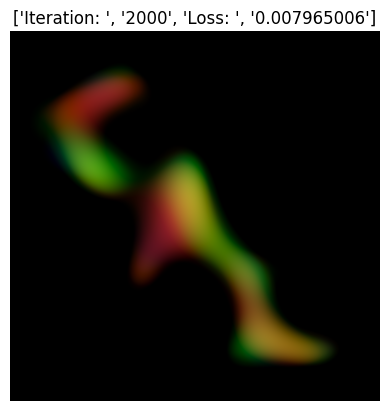

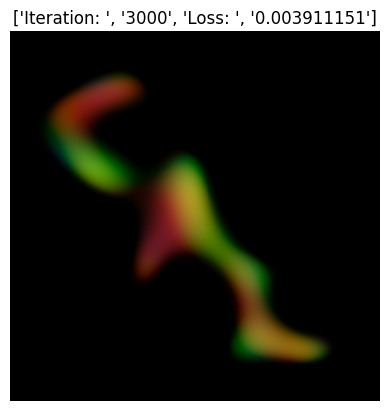

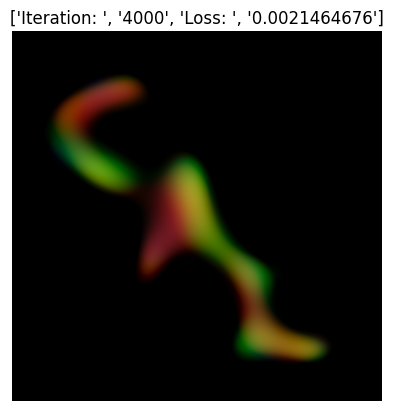

In [37]:
# do recon on diffuser measurement
# define the optimizer
kmax = 5000
kprint = 1000 #show halfway
step_size = 1e-2
thr = 0 #6e-5 #3e-6 is ok
xytv =  0 #1e-6 #1e-4 is big
lamtv = 0#  2e-6 #2e-6 is ok
optimizer = optax.adam(learning_rate=step_size)

# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(sdc.loss_func, (0)))
# initialize the reconstruction
xk_stack = [np.zeros_like(x) for l in range(len(meas_stack))]

for k0 in range(len(meas_stack)):
    print(k0)
    meas = meas_stack[k0]
    psf = psf_stack[k0]
    hpad = jnp.asarray(sdc.pad(torch.Tensor(psf)))
    hfftpad = jnp.fft.fft2(hpad)[None, ...]
    m = jnp.asarray(spectral_filter)
    meas = jnp.asarray(meas/np.amax(meas))

    padding = ((0,0,0),(np.ceil(m.shape[1]/2).astype(int),np.floor(m.shape[1]/2).astype(int),0),(np.ceil(m.shape[2]/2).astype(int),np.floor(m.shape[2]/2).astype(int),0))
    # calculate the adjoint
    xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)
    # Initialize optimizer state
    opt_state = optimizer.init(xk)  
    plt.figure()
    plt.imshow(np.sum(xk,axis=0))
    plt.axis('off')
    plt.colorbar()
    plt.title('Initial Guess')
    plt.show()

    for k in range(kmax):
        loss, grad = loss_and_grad(xk, meas, m, hfftpad, thr, xytv, lamtv)
        updates, opt_state = optimizer.update(grad, opt_state)
        updates = jnp.nan_to_num(updates)
        # break
        xk = optax.apply_updates(xk, updates)
        xk = jnp.clip(xk, 0, None)
        if k%kprint == 0:
            HSI_data = np.reshape(np.transpose(xk, (1,2,0)), [-1,dim0])
            false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
            plt.figure()
            plt.imshow(false_color**1.8)
            plt.axis('off')
            plt.title(['Iteration: ', str(k), 'Loss: ', str(loss)])
            # plt.colorbar()
            plt.show()
    # save the reconstruction
    xk_stack[k0] = xk


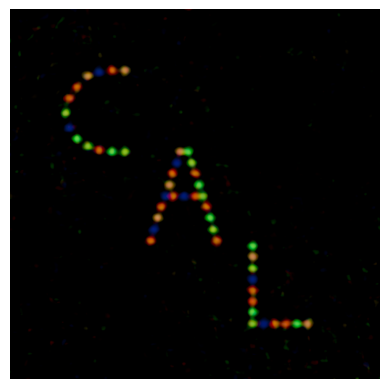

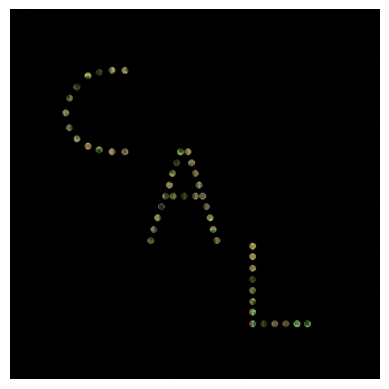

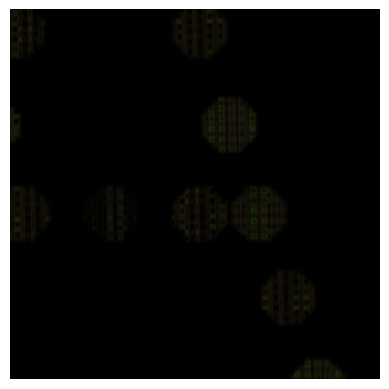

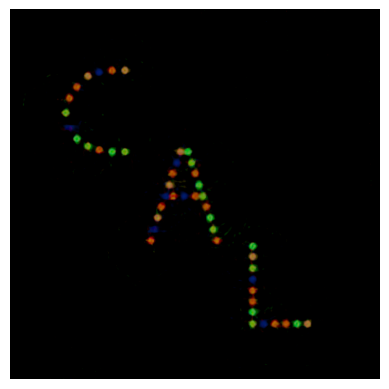

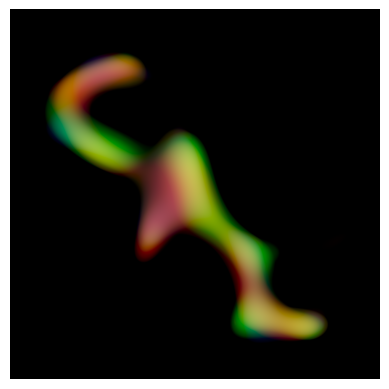

In [38]:
# plot final result. 
for k0 in xk_stack:
    HSI_data = np.reshape(np.transpose(k0, (1,2,0)), [-1,dim0])
    false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
    plt.figure()
    plt.imshow(false_color**1)
    plt.axis('off')
    # plt.colorbar()

In [184]:

# # Create a dictionary
# x_dict = {}

# x_dict['x_mag'] = x_mag
# x_dict['x_blur'] = x_blur
# x_dict['x_delta'] = x_delta
# x_dict['x_diffuser'] = x_diffuser
# x_dict['x_gt'] = x

# import pickle
# # Specify the file path where you want to save the dictionary
# file_path = './Figures/calbeadsim/x_recons.pkl'

# # Save the dictionary to the file
# with open(file_path, 'wb') as file:
#     pickle.dump(x_dict, file)
# # Print the dictionary
# print(x_dict)

{'x_mag': Array([[[3.4455545e-02, 3.5274789e-02, 7.5399995e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4754336e-02, 3.5522029e-02, 7.4589446e-02, ...,
         0.0000000e+00, 0.0000000e+00, 9.4611907e-10],
        [3.3117846e-02, 3.2262791e-02, 6.7715615e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.4463752e-02, 3.5255618e-02, 7.5364724e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4742568e-02, 3.5507713e-02, 7.4567370e-02, ...,
         0.0000000e+00, 0.0000000e+00, 2.2783935e-09],
        [3.3104122e-02, 3.2249074e-02, 6.7699686e-02, ...,
    

In [ ]:
## try to add more noise to defocus psf?
